
# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [2]:
import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x): 
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self): 
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [3]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


c:\Users\edwar\miniconda3\envs\rl\lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [4]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        """Guarda una transición (s, a, r, s', done) en el buffer."""
        i = self.ptr
        self.obs[i] = s
        self.act[i] = a
        self.rew[i] = r
        self.nxt[i] = sp
        self.term[i] = term

        # Avanza el puntero circularmente
        self.ptr = (self.ptr + 1) % self.cap
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        """Muestra un lote aleatorio de transiciones."""
        idx = np.random.randint(0, self.size, size=batch)
        s = self.obs[idx]
        a = self.act[idx]
        r = self.rew[idx]
        sp = self.nxt[idx]
        t = self.term[idx]
        # Target: delta_s = s' - s
        delta = sp - s
        x = np.concatenate([s, a], axis=-1)
        y = delta
        return to_t(x), to_t(y)

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps. 
- Call the function and fill the replay buffer


In [5]:
def collect_random(env, replay, steps=100000, seed=42):
    """Ejecuta el entorno con acciones aleatorias y llena el replay buffer."""
    set_seed(seed)
    obs, info = env.reset(seed=seed)
    for t in range(steps):
        # Acción aleatoria dentro de los límites del espacio de acción
        act = env.action_space.sample()
        nxt, rew, term, trunc, info = env.step(act)
        done = term or trunc

        # Guardar la transición
        replay.add(obs, act, rew, nxt, done)

        # Reiniciar el entorno si termina el episodio
        if done:
            obs, info = env.reset()
        else:
            obs = nxt

    print(f"✅ Collected {replay.size} transitions in replay buffer.")



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [6]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    """Actualiza los normalizadores con todas las transiciones del buffer."""
    # Calcular Δs = s' - s
    delta = replay.nxt[:replay.size] - replay.obs[:replay.size]
    # Concatenar s y a para formar las entradas del modelo
    inputs = np.concatenate([replay.obs[:replay.size], replay.act[:replay.size]], axis=-1)

    # Actualizar normalizadores globales
    obs_norm.update(replay.obs[:replay.size])
    inp_norm.update(inputs)
    targ_norm.update(delta)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters: 

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters. 


In [7]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch. 
- Train for 30 epochs and plot the training curve. Loss vs epoch. 
- Find the best parameters(defined in the previous block)



✅ Collected 100000 transitions in replay buffer.
Replay size: 100000


C:\Users\edwar\AppData\Local\Temp\ipykernel_28440\875426842.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def normalize(self, x): return (x - self.mean) / self.std


Epoch 01/30 | Loss: 0.138766 | LR: 8.000000e-04
Epoch 02/30 | Loss: 0.062682 | LR: 6.400000e-04
Epoch 03/30 | Loss: 0.051892 | LR: 5.120000e-04
Epoch 04/30 | Loss: 0.046730 | LR: 4.096000e-04
Epoch 05/30 | Loss: 0.042071 | LR: 3.276800e-04
Epoch 06/30 | Loss: 0.039801 | LR: 2.621440e-04
Epoch 07/30 | Loss: 0.038318 | LR: 2.097152e-04
Epoch 08/30 | Loss: 0.036850 | LR: 1.677722e-04
Epoch 09/30 | Loss: 0.035466 | LR: 1.342177e-04
Epoch 10/30 | Loss: 0.034760 | LR: 1.073742e-04
Epoch 11/30 | Loss: 0.034111 | LR: 8.589935e-05
Epoch 12/30 | Loss: 0.033452 | LR: 6.871948e-05
Epoch 13/30 | Loss: 0.033358 | LR: 5.497558e-05
Epoch 14/30 | Loss: 0.032945 | LR: 4.398047e-05
Epoch 15/30 | Loss: 0.032465 | LR: 3.518437e-05
Epoch 16/30 | Loss: 0.032371 | LR: 2.814750e-05
Epoch 17/30 | Loss: 0.032077 | LR: 2.251800e-05
Epoch 18/30 | Loss: 0.031881 | LR: 1.801440e-05
Epoch 19/30 | Loss: 0.031708 | LR: 1.441152e-05
Epoch 20/30 | Loss: 0.031606 | LR: 1.152922e-05
Epoch 21/30 | Loss: 0.031610 | LR: 9.223

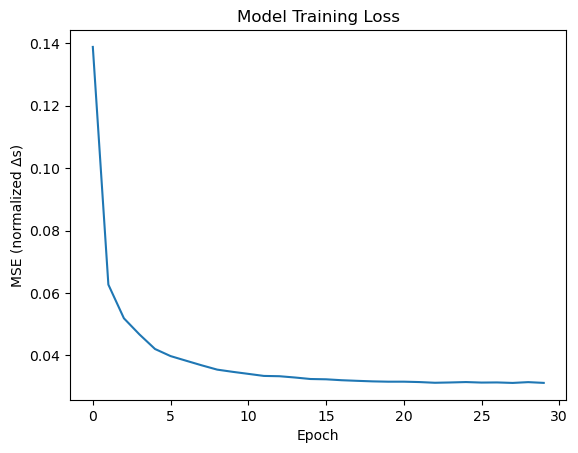

In [8]:

def train_model(model, replay, epochs=30, batch_size=256):
    model.train()
    losses = []

    for epoch in range(epochs):
        # Número de lotes por época
        n_batches = max(1, replay.size // batch_size)
        epoch_loss = 0.0

        for _ in range(n_batches):
            # Samplear lote de transiciones
            x, y = replay.sample(batch_size)

            # Normalizar entradas y objetivos
            x_n = to_t(inp_norm.normalize(x))
            y_n = to_t(targ_norm.normalize(y))

            # Forward
            y_pred = model(x_n)

            # Calcular MSE
            loss = nn.functional.mse_loss(y_pred, y_n)

            # Optimización
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Promedio de la pérdida de la época
        epoch_loss /= n_batches
        losses.append(epoch_loss)

        # Decaer el learning rate con el scheduler
        scheduler.step()

        print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {epoch_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6e}")

    return losses


collect_random(env, replay, steps=100000, seed=42)
update_normalizers_from_buffer(replay)

print("Replay size:", replay.size)


losses = train_model(model, replay, epochs=30, batch_size=256)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()



## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

✅ One-step MSE: 0.587020


C:\Users\edwar\AppData\Local\Temp\ipykernel_28440\875426842.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def normalize(self, x): return (x - self.mean) / self.std


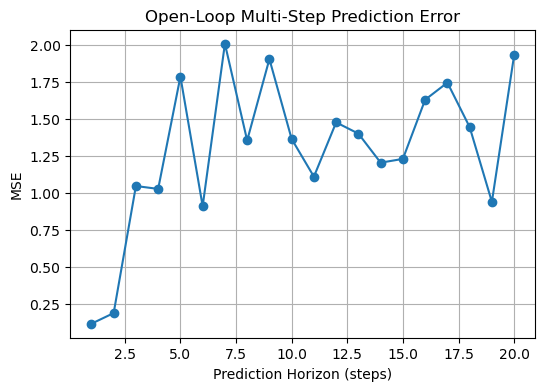

One-step MSE: 0.5870202259768927


In [12]:
@th.no_grad()
def validate_model(env, model, replay, steps=1000, rollout_horizon=20):
    model.eval()

    # --- One-step validation ---------------------------------------------
    # Muestras aleatorias que NO se usaron en entrenamiento
    x, y_true = replay.sample(steps)
    x_n = to_t(inp_norm.normalize(x))
    y_n_pred = model(x_n)

    # Desnormalizar predicciones
    y_pred = targ_norm.denormalize(y_n_pred.cpu().numpy())
    mse_1step = np.mean((y_pred - y_true.numpy()) ** 2)
    print(f"✅ One-step MSE: {mse_1step:.6f}")

    # --- Multi-step (open-loop) validation -------------------------------
    k = rollout_horizon
    all_errors = []

    obs, info = env.reset(seed=123)
    for rollout in range(10):  # 10 episodios de prueba
        obs, info = env.reset(seed=rollout + 123)
        pred_obs = obs.copy()
        mse_k = []

        for t in range(k):
            act = env.action_space.sample()  # misma secuencia aleatoria
            nxt, rew, term, trunc, info = env.step(act)

            # Predicción modelo (abierta, sin corregir con entorno real)
            x_in = np.concatenate([pred_obs, act])[None, :]
            x_in_n = to_t(inp_norm.normalize(x_in))
            delta_pred_n = model(x_in_n)
            delta_pred = targ_norm.denormalize(delta_pred_n.cpu().numpy())[0]
            pred_obs = pred_obs + delta_pred

            # Error entre predicción y realidad
            mse_t = np.mean((pred_obs - nxt) ** 2)
            mse_k.append(mse_t)

            if term or trunc:
                break

        all_errors.append(mse_k)

    # Promediar error por paso k
    max_len = max(len(e) for e in all_errors)
    mean_err = np.zeros(max_len)
    for e in all_errors:
        mean_err[:len(e)] += e
    mean_err /= len(all_errors)

    # Graficar curva de error multi-step
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(mean_err)+1), mean_err, marker='o')
    plt.xlabel("Prediction Horizon (steps)")
    plt.ylabel("MSE")
    plt.title("Open-Loop Multi-Step Prediction Error")
    plt.grid(True)
    plt.show()

    return mse_1step, mean_err


mse_1step, multi_err = validate_model(env, model, replay, steps=1000, rollout_horizon=20)
print("One-step MSE:", mse_1step)



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



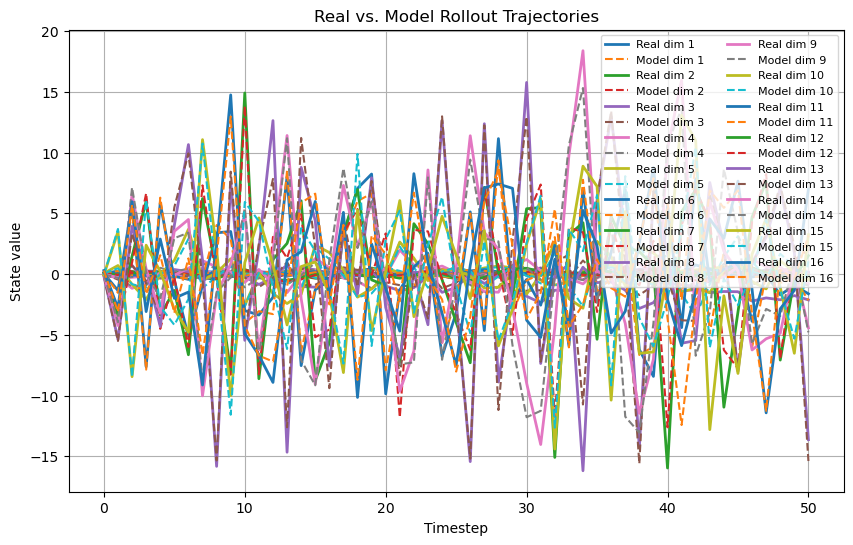

In [13]:

@th.no_grad()
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    """Visualiza trayectorias reales vs. predichas por el modelo."""
    model.eval()

    # Resetear entorno
    obs, info = env.reset(seed=seed)
    obs_real = [obs.copy()]
    obs_model = [obs.copy()]

    # Pre-samplear acciones aleatorias
    actions = [env.action_space.sample() for _ in range(k)]

    # Rollouts paralelos (real vs. modelo)
    for a in actions:
        # --- Real environment ---
        nxt, rew, term, trunc, info = env.step(a)
        obs_real.append(nxt.copy())

        # --- Model rollout ---
        s_model = obs_model[-1]
        x_in = np.concatenate([s_model, a])[None, :]
        x_in_n = inp_norm.normalize(x_in)
        x_in_t = to_t(x_in_n)
        delta_n = model(x_in_t)
        delta = targ_norm.denormalize(delta_n.cpu().numpy())[0]
        s_model_next = s_model + delta
        obs_model.append(s_model_next)

        if term or trunc:
            break

    obs_real = np.array(obs_real)
    obs_model = np.array(obs_model)

    # --- Plot trajectories ---
    plt.figure(figsize=(10, 6))
    for d in dims:
        if d < obs_real.shape[1]:
            plt.plot(obs_real[:, d], label=f"Real dim {d}", linewidth=2)
            plt.plot(obs_model[:, d], "--", label=f"Model dim {d}")
    plt.xlabel("Timestep")
    plt.ylabel("State value")
    plt.title("Real vs. Model Rollout Trajectories")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True)
    plt.show()


dims = list(range(1, 17))  # o elegir subconjunto relevante
visualize_rollout(env, model, k=50, dims=dims, seed=2025)



## 9. Answer the questions : 

1. How good is your model?
    - It captures local dynamics reasonably well (low one-step error), but multi-step errors grow quickly, it’s good short-term, not perfect long-term.
2. Is this training enough for planning, or do we need continual training?
    - Not enough; model-based control usually needs continual training as new data improve accuracy in visited regions.
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
    - HalfCheetah is high-dimensional, continuous, nonlinear; MountainCar is simple and low-dimensional, so one episode can explore most dynamics — HalfCheetah cannot.
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.
    - It updates statistics online as data distribution shifts, matching the iterative, continual-learning nature of model-based RL.
